In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import datetime
from datetime import time
from pandas.tseries.frequencies import to_offset

In [4]:
import re
import json
import csv
from io import StringIO
from bs4 import BeautifulSoup
import requests

In [5]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

# BA boeing company, data from Yahoo finanse
stock_d = data.DataReader('BA', 'yahoo', start, end)

def week_open(array_like):
    return array_like[0]

def week_close(array_like):
    return array_like[-1]

logic = {'Open': week_open, 
                         'High': 'max',
                         'Low': 'min',
                         'Close': week_close,
                         'Volume': 'sum'}

stock_w = stock_d.resample('W').apply(logic) # Converting daily data to weekly
stock_w.index -= to_offset('6D')

stock_w = stock_w[['Open', 'High', 'Low', 'Close', 'Volume']]

### Klausimas dėstytojui, kaip kitaip patestuoti, ar gerai transformuoti duomenys?

In [6]:
print(stock_d.head(10))
stock_w.head()

               High      Low     Open    Close     Volume  Adj Close
Date                                                                
2000-01-03  41.6875  39.8125  41.4375  40.1875  2638200.0  25.940271
2000-01-04  41.1250  39.7500  40.1875  40.1250  3592100.0  25.899939
2000-01-05  43.3125  41.3750  41.3750  42.6250  7631700.0  27.513638
2000-01-06  43.4375  41.1250  42.6250  43.0625  4922200.0  27.796049
2000-01-07  44.8750  43.6875  43.6875  44.3125  6008300.0  28.602879
2000-01-10  44.5000  43.5000  44.3125  43.6875  2403500.0  28.199469
2000-01-11  43.9375  42.7500  43.6875  42.8750  2450000.0  27.675016
2000-01-12  44.1875  42.5000  42.8750  43.0625  2327800.0  27.796049
2000-01-13  43.3750  42.0000  43.0625  42.3750  3035100.0  27.352268
2000-01-14  44.2500  42.9375  42.9375  44.0000  3834900.0  28.401180


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,41.4375,44.8750,39.7500,44.3125,24792500.0
2000-01-10,44.3125,44.5000,42.0000,44.0000,14051300.0
2000-01-17,44.0000,48.1250,43.1250,45.6875,30657000.0
2000-01-24,45.6875,46.8750,43.6250,44.6250,17080700.0
2000-01-31,44.5625,45.1875,42.5625,44.0000,14199400.0


In [27]:
stock_w.shape

(1171, 5)

### Checking if we have right numbers after reshaping

In [7]:
# Volume
first_week_volume = stock_d['Volume'][0:5].sum()
first_week_volume_rsh = stock_w.Volume[0]

# Close
first_week_close = stock_d['Close'][4]
first_week_close_rsh = stock_w['Close'][0]

# Low
first_week_low = stock_d['Low'][0:5].min()
first_week_low_rsh = stock_w['Low'][0]

# High
first_week_high = stock_d['High'][0:5].max()
first_week_high_rsh = stock_w['High'][0]

# Open
first_week_open = stock_d['Open'][0]
first_week_open_rsh = stock_w['Open'][0]


In [8]:
print(f'First week volume sum is correct? {first_week_volume == first_week_volume_rsh}')
print(f'First week close price is correct? {first_week_close == first_week_close_rsh}')
print(f'First week low price is correct? {first_week_low == first_week_low_rsh}')
print(f'First week high price is correct? {first_week_high == first_week_high_rsh}')
print(f'First week open price is correct? {first_week_open == first_week_open_rsh}')

First week volume sum is correct? True
First week close price is correct? True
First week low price is correct? True
First week high price is correct? True
First week open price is correct? True


#### We will focus on close price which is the standar benchmark regarding stocks and securities.

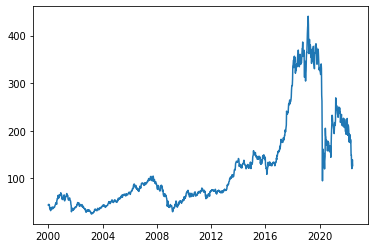

In [9]:
plt.plot(stock_w.Close)

(array([427., 288., 177.,  68.,  56.,  38.,   8.,  67.,  37.,   5.]),
 array([ 25.54999924,  67.05699883, 108.56399841, 150.070998  ,
        191.57799759, 233.08499718, 274.59199677, 316.09899635,
        357.60599594, 399.11299553, 440.61999512]),
 <BarContainer object of 10 artists>)

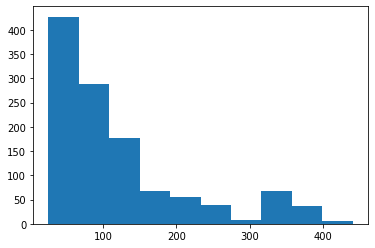

In [10]:
plt.hist(stock_w.Close)

#### Building the LSTM model

In [24]:
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [16]:
# create a new data frame with only 'Close column'
data = stock_w.filter(['Close'])
dataset = data.values #convert the data frame to a numpy array
training_data_len = math.ceil(len(dataset)*.8)  # number of rows to train the model on
training_data_len

937

In [19]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04520322],
       [0.04445034],
       [0.04851592],
       ...,
       [0.25701688],
       [0.2739297 ],
       [0.24441661]])

In [20]:
#create the training dataset
#create the scaled training dataset

train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train, y_train datasets
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.04520322, 0.04445034, 0.04851592, 0.04595611, 0.04445034,
       0.03451225, 0.02517648, 0.02954321, 0.0250259 , 0.01644301,
       0.02999494, 0.02517648, 0.02954321, 0.02442359, 0.02367071,
       0.03496398, 0.03406052, 0.03360879, 0.02803744, 0.02743513,
       0.03059725, 0.03451225, 0.03285591, 0.03300648, 0.03451225,
       0.03918014, 0.04384803, 0.04550438, 0.0512263 , 0.05604477,
       0.0564965 , 0.05800227, 0.04851592, 0.06884381, 0.07034958,
       0.07848074, 0.0754692 , 0.09143036, 0.0938396 , 0.08540728,
       0.07998651, 0.08299805, 0.09203267, 0.09760402, 0.09143036,
       0.09594767, 0.09670056, 0.09700171, 0.1069398 , 0.09474306,
       0.09127979, 0.09745344, 0.07998651, 0.08450382, 0.07260824,
       0.07833016, 0.07540897, 0.07658949, 0.08297396, 0.08687692])]
[0.08323897072781589]



In [21]:
#convert the x_train and y_train  to numppy array
x_train,y_train = np.array(x_train), np.array(y_train)

In [22]:
#reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(877, 60, 1)

In [25]:
#Buil the LSTM model
model =Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(1))

In [28]:
#Complie the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
#Train the model
model.fit(x_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
877/877 [==============================] - 17s 16ms/step - loss: 0.0010
Epoch 2/10
877/877 [==============================] - 14s 16ms/step - loss: 3.8516e-04
Epoch 3/10
877/877 [==============================] - 16s 18ms/step - loss: 3.5418e-04
Epoch 4/10
877/877 [==============================] - 17s 19ms/step - loss: 3.6741e-04
Epoch 5/10
877/877 [==============================] - 17s 19ms/step - loss: 1.9218e-04
Epoch 6/10
877/877 [==============================] - 17s 19ms/step - loss: 6.1566e-04
Epoch 7/10
877/877 [==============================] - 18s 20ms/step - loss: 3.4260e-04
Epoch 8/10
877/877 [==============================] - 17s 20ms/step - loss: 1.6453e-04
Epoch 9/10
877/877 [==============================] - 18s 20ms/step - loss: 1.4322e-04
Epoch 10/10
877/877 [==============================] - 18s 20ms/step - loss: 1.7328e-04


In [30]:
#create the testing data sets
#create a new array containing scale values
test_data= scaled_data[training_data_len-60:, :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [31]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [32]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(234, 60, 1)

In [33]:
#predicting the data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [34]:
#get the root mean square error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.4944581577920506

C:\Users\SN\AppData\Local\Temp\ipykernel_11080\3512275700.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


ValueError: 'upper_center' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

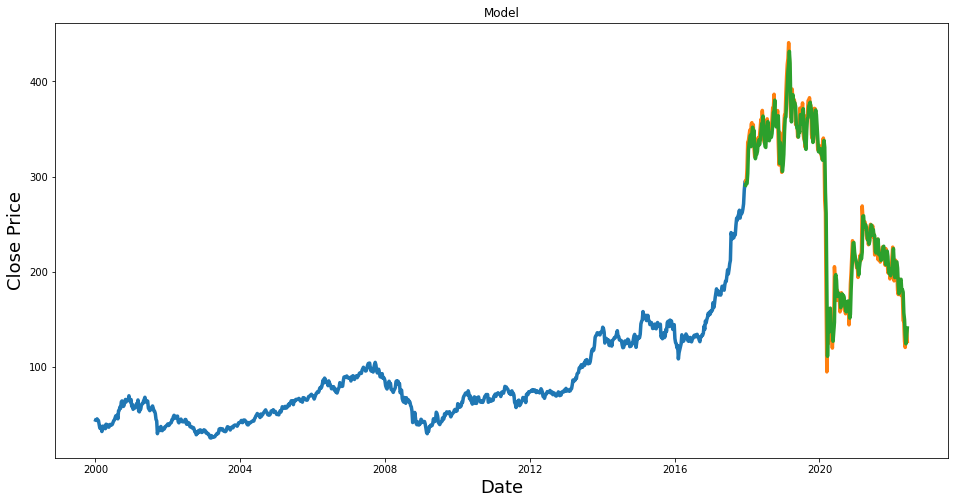

In [35]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visialization the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(train['Close'],linewidth=3.5)
plt.plot(valid[['Close','Predictions']],linewidth=3.5)
plt.legend(['Train','Valid','Predictions'], loc='upper_center')

In [36]:
#show the valid and predicted price
valid

,Close,Predictions
Date,,
2017-12-18,295.100006,290.962646
2017-12-25,294.910004,293.357697
2018-01-01,308.839996,292.719788
2018-01-08,336.209991,303.040436
2018-01-15,337.730011,327.733124
...,...,...
2022-05-09,127.199997,149.957275
2022-05-16,120.699997,133.615570
2022-05-23,132.229996,124.509415


### Add extra financial data

In [92]:
# url_stats = 'https://finance.yahoo.com/quote/{}/key-statistics?p={}'
# url_profile = 'https://finance.yahoo.com/quote/{}/profile?p={}'
# url_financials = 'https://finance.yahoo.com/quote/{}/financials?p={}'

# stock = 'BA'

In [96]:
# response = requests.get(url_financials.format(stock, stock))
# soup = BeautifulSoup(response.text, 'html.parser')